In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

%matplotlib inline

In [2]:
# reference:
ref_annot = pd.read_csv('../data/raw/ref_annot.csv')

In [3]:
REGION_SIZE = 50

In [4]:
WINDOW_SIZE = 10

In [5]:
g4conf = pd.read_csv('../data/processed/g4conf.csv')

In [7]:
g4pqs = pd.read_csv('../data/raw/pqsfinder_mtDNA_human_th15.csv')

In [7]:
g4pqsconf = pd.read_csv('../data/processed/g4pqsconf.csv')

In [8]:
def add_columns(df:pd.DataFrame): # data_preparation step 2
    
    bp_untill_next_G4 = df['start'].drop(0).values - df['end'].drop(df.shape[0]-1).values
    bp_untill_next_G4 = bp_untill_next_G4.tolist()
    bp_untill_next_G4.append(len(ref_annot['Pos']) - df['end'][len(df['start'])-1] + df['start'][0])  #bp between last G4 and first G4

    bp_untill_previous_G4 = df['start'].drop(0).values - df['end'].drop(df.shape[0]-1).values
    bp_untill_previous_G4 = bp_untill_previous_G4.tolist()
    bp_untill_previous_G4.insert(0, len(ref_annot['Pos']) - df['end'][len(df['start'])-1] + df['start'][0]) #bp between fist and last

    df['bp_untill_next_G4'] = bp_untill_next_G4
    df['bp_untill_previous_G4'] = bp_untill_previous_G4

    if 'G4_id' in df.columns:
        None
    else:
        df['G4_id'] = [*range(1,df.shape[0]+1)]

    df['up_win'] = pd.concat([df[df['bp_untill_previous_G4'] <= 100][['bp_untill_previous_G4', 'start']]\
                                  .diff(axis=1)['start'],\
                                 df[df['bp_untill_previous_G4'] > 100]['start']-100])
    
    df['down_win'] = pd.concat([df[df['bp_untill_next_G4'] <= 100][['end', 'bp_untill_next_G4']]\
                                    .sum(axis=1), \
                               df[df['bp_untill_next_G4'] > 100]['end']+100])
    return df

In [9]:
def make_win_up(df:pd.DataFrame()): #data preparation step 3, windows around G4
    
    data_up = []
    
    for up_win, start, G4_id in zip(df['up_win'], df['start'], df['G4_id']):
        
        count_window = start - up_win - WINDOW_SIZE + 1  # count window in upstream interval (before G4)
        number_of_win = count_window + 1                 # reverse counting of windows; the closer to G4, the smaller the number
        
        for i in range(up_win, start):
            row = []
            
            if i+WINDOW_SIZE <= start:
                window = [*range(i, i + WINDOW_SIZE)]
            else:
                break
    #         print(i, window)    
            window_seq = ''
            for pos in window:
                if pos != 3107:
                    window_seq += str(ref_annot[ref_annot['Pos'] == pos].Nuc.values[0])
                else:
                    window_seq += ''
    #         print(pos, window_seq)
    
    #       ref_annot[ref_annot['Pos'].isin(window)].Nuc.value_counts()
            
            number_of_win -= 1
            
            row.append(G4_id)
            row.append('up')
            row.append(number_of_win)
            row.append(window[0])
            row.append(window[-1])
            row.append(window_seq)
            
            data_up.append(row)
    # print(data_up)
    return data_up

In [10]:
def make_win_down(df:pd.DataFrame()): #data preparation step 3, windows around G4
    data_down = []
    
    for end, down_win, G4_id in zip(df['end'], df['down_win'], df['G4_id']):
        
        number_of_win = 0
        
        for i in range(end, down_win):
            row = []
            
            if i >= g4conf['end'].iloc[-1] | i <= ref_annot['Pos'].iloc[-1]:
                window = [*range(i, ref_annot['Pos'].iloc[-1]+1)]
                remain = WINDOW_SIZE - (ref_annot['Pos'].iloc[-1] - i)
                window += [*range(ref_annot['Pos'].iloc[0], remain)]
            
            elif i > ref_annot['Pos'].iloc[-1] and i <= down_win - WINDOW_SIZE :
                i = i - ref_annot['Pos'].iloc[-1]
                window = [*range(i, i + WINDOW_SIZE)]
            
            elif i+WINDOW_SIZE < down_win:
                window = [*range(i, i + WINDOW_SIZE)]
                   
            else:
                break
                
            window_seq = ''
            for pos in window:
                window_seq += ref_annot[ref_annot['Pos'] == pos].Nuc.values[0]
    #         print(window[0], window_seq)
    
    #     ref_annot[ref_annot['Pos'].isin(window)].Nuc.value_counts()
    
            number_of_win += 1
    
            row.append(G4_id)
            row.append('down')
            row.append(number_of_win)
            row.append(window[0])
            row.append(window[-1])
            row.append(window_seq)
            
            data_down.append(row)
    # print(data_down)
    return data_down

In [11]:
def make_win_df(data_up, data_down): #data preparation step 3, df_win around G4 and within G4
    data = data_up + data_down
    df_win = pd.DataFrame(data=data, columns = ['G4_id', 'side', 'number_of_win', 'window_start', 'window_end', 'sequence'])
    nuc_count_win = df_win['sequence'].apply(lambda x: Counter(x))
    nuc_count_df_win = pd.DataFrame.from_records(nuc_count_win).sort_index(axis=1)
    df_win = df_win.join(nuc_count_df_win).fillna(0)
    return df_win

In [12]:
def make_win_start_within(df:pd.DataFrame):
    data_within_start = []
    
    for start, end, G4_id, sequence in zip(df['start'], df['end'], df['G4_id'], df['sequence']):
        
        number_of_win = 0
        
        for i, j in zip(range(start, end), range(len(sequence))):
            row = []
            
            if i+WINDOW_SIZE <= end:
                window = [*range(i, i + WINDOW_SIZE)]       
            else:
                break
            
            # print(i, window, WINDOW_SIZE, end)    
            window_seq = ''
            window_seq += sequence[j: j + WINDOW_SIZE]
    
            
            number_of_win += 1
    
            row.append(G4_id)
            row.append('within_start')
            row.append(number_of_win)
            row.append(window[0])
            row.append(window[-1])
            row.append(window_seq)
            
            data_within_start.append(row)
    # print(data_down)
    return data_within_start

In [13]:
def make_win_end_within(df:pd.DataFrame):
    data_within_end = []
    
    for start, end, G4_id, sequence in zip(df['start'], df['end'], df['G4_id'], df['sequence']):
        
        number_of_win = 0
        
        for i, j in zip(range(end, start, -1), range(len(sequence))):
            row = []
    
            
            if i+WINDOW_SIZE > end:
                continue  
            elif (i+WINDOW_SIZE <= end):
                window = [*range(i, i + WINDOW_SIZE)]       
            else:
                continue
            # print(window)
            
            window_seq = ''
            window_seq += sequence[::-1][j-10:j+WINDOW_SIZE-10][::-1]   #window_seq from the end. works with '-10' 
    
            # print(i, j)
            
            number_of_win += 1
    
            row.append(G4_id)
            row.append('within_end')
            row.append(number_of_win)
            row.append(window[0])
            row.append(window[-1])
            row.append(window_seq)
            
            data_within_end.append(row)
    # print(data_down)
    return data_within_end

In [132]:
def collect_mut_cancer(df_cancers:pd.DataFrame, df_win:pd.DataFrame, regime:str):
    if regime == '2col':
        Mut_win = []
        for window_start, window_end in zip(df_win['window_start'], df_win['window_end']):
            row = [*range(window_start, window_end)]
            Mut_win.append(str(df_cancers[df_cancers['Pos'].isin(row)].Mut.values))
    elif regime == '1col':
        Mut_win = []
        for row in df_win['positions']:
            Mut_win.append(str(df_cancers[df_cancers['Pos'].isin( \
                list(map(int, row.strip('[]').replace(' ', '').split(','))) \
                                                                )].Mut.values))
            
    elif regime == 'pos':
        Mut_win = []
        for i in df_win['pos_in_ref']:
            Mut_win.append(str(df_cancers[df_cancers['Pos'] == i].Mut.values))
    
    Mut_win_df = pd.DataFrame(Mut_win)
    Mut_win_df[0] = Mut_win_df[0].str.findall("[A-T]>[A-T]")
    obsMutwin = pd.DataFrame.from_records(Mut_win_df[0].apply(lambda x: Counter(x))).fillna(0).sort_index(axis=1)
    df_win_cancer = df_win.join(obsMutwin)
    df_win_cancer['number_of_Mut'] = df_win_cancer[['A>C','A>G','A>T',
                                                    'C>A','C>G','C>T',
                                                'G>A','G>C','G>T',
                                                'T>A','T>C','T>G']].sum(axis=1)
    return df_win_cancer

In [16]:
def add_columns_15(df:pd.DataFrame): #for category
    df['15_up'] = pd.concat([df[df['bp_untill_previous_G4'] < 15][['bp_untill_previous_G4', 'start']]\
                                      .diff(axis=1)['bp_untill_previous_G4'],\
                                     df[df['bp_untill_previous_G4'] >= 15]['start']-15])
        
    df['15_down'] = pd.concat([df[df['bp_untill_next_G4'] < 15][['end', 'bp_untill_next_G4']]\
                                        .diff(axis=1)['end'], \
                                   df[df['bp_untill_next_G4'] >= 15]['end']+15])
    
    df['30_up'] = pd.concat([df[df['bp_untill_previous_G4'] < 30][['bp_untill_previous_G4', 'start']]\
                                      .diff(axis=1)['bp_untill_previous_G4'],\
                                     df[df['bp_untill_previous_G4'] >= 30]['start']-30])
        
    df['30_down'] = pd.concat([df[df['bp_untill_next_G4'] < 30][['end', 'bp_untill_next_G4']]\
                                        .diff(axis=1)['end'], \
                                   df[df['bp_untill_next_G4'] >= 30]['end']+30])
    
    df['45_up'] = pd.concat([df[df['bp_untill_previous_G4'] < 45][['bp_untill_previous_G4', 'start']]\
                                      .diff(axis=1)['bp_untill_previous_G4'],\
                                     df[df['bp_untill_previous_G4'] >= 45]['start']-45])
        
    df['45_down'] = pd.concat([df[df['bp_untill_next_G4'] < 45][['end', 'bp_untill_next_G4']]\
                                        .diff(axis=1)['end'], \
                                   df[df['bp_untill_next_G4'] >= 45]['end']+45])
    return df

# Data preparation

## Step 1
- auto-annotate G4 by G4Hunter (https://bioinformatics.cruk.cam.ac.uk/G4Hunter/)  
- *verificate auto-annotate G4 in human RefSeq using data from africa paper and exel*
- auto-annotate and auto-labeling G4 by pqsfinder (https://pqsfinder.fi.muni.cz/)
- compare two datasets (from G4hunter and from pqsfinder)

Dataset from paper [DOI:10.1093/nar/gkw006](DOI:10.1093/nar/gkw006) (G4Hunter and *in vitro* checking G4)

In [5]:
datasetG4 = pd.read_excel("../data/raw/SupplementaryTableS2.xlsx")

C:\Users\777\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():
C:\Users\777\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [6]:
africaG4 = datasetG4[datasetG4['Type'] != 'notG4'][['seqnames','start','end', 'width', 'strand', 'seq', 'G4Hscore', 'Type']]

In [7]:
# africaG4.to_excel('data/processed/africaG4.xlsx')

In [8]:
refG4 = pd.read_table('../data/raw/NC_012920.1 Homo sapiens mitochondrion, complete genome_DNA_hl=1_k=25_G4Hseeked_2023-09-22.txt')

In [9]:
# refG4.to_excel('data/processed/refG4.xlsx')

## OLD Manually fill in the data  
Compare two datasets africaG4, refG4  
If G4 present in both datasets put **1** in column *confirm*

## NEW pqsfinder labeling

In [8]:
refG4 = pd.read_excel('../data/processed/refG4.xlsx')

In [9]:
refG4

,seqnames,start,end,width,strand,score,max_score,threshold,window,sequence,confirmed,G4,note,start-100bp,end+100bp
0,"NC_012920.1 Homo sapiens mitochondrion, comple...",47,90,44,+,0.636,1.12,1,25,GCATTTGGTATTTTCGTCTGGGGGGTATGCACGCGATAGCATTG,0,-,NaN,16516,190
1,"NC_012920.1 Homo sapiens mitochondrion, comple...",285,332,48,-,-1.250,-2.24,1,25,CAAAAAATTTCCACCAAACCCCCCCTCCCCCGCTTCTGGCCACAGCAC,1,G4,more than africa,185,432
2,"NC_012920.1 Homo sapiens mitochondrion, comple...",348,378,31,-,-1.100,-1.16,1,25,CCAAACCCCAAAAACAAAGAACCCTAACACC,1,UG4,less than africa,248,478
3,"NC_012920.1 Homo sapiens mitochondrion, comple...",418,592,175,-,-1.150,-1.88,1,25,CACTTTTAACAGTCACCCCCCAACTAACACATTATTTTCCCCTCCC...,1,G4,5 overlapping g4 in africa,318,692
4,"NC_012920.1 Homo sapiens mitochondrion, comple...",702,728,27,-,-1.040,-1.08,1,25,CATCCCCGTTCCAGTGAGTTCACCCTC,0,-,NaN,602,828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,"NC_012920.1 Homo sapiens mitochondrion, comple...",16033,16049,17,+,1.530,1.00,1,25,GGGGAAGCAGATTTGGG,0,-,NaN,15933,16149
90,"NC_012920.1 Homo sapiens mitochondrion, comple...",16167,16211,45,-,-1.160,-1.80,1,25,CCCAATCCACATCAAAACCCCCTCCCCATGCTTACAAGCAAGTAC,1,G4,more than africa,16067,16311
91,"NC_012920.1 Homo sapiens mitochondrion, comple...",16239,16301,63,-,-0.968,-1.40,1,25,CAACTGCAACTCCAAAGCCACCCCTCACCCACTAGGATACCAACAA...,1,G4,more than africa,16139,16401
92,"NC_012920.1 Homo sapiens mitochondrion, comple...",16344,16382,39,-,-1.210,-1.48,1,25,CAGTCAAATCCCTTCTCGTCCCCATGGATGACCCCCCTC,1,UG4,more than africa,16244,16482


In [9]:
g4pqs

,sequenceName,start,end,score,strand,pattern,nt,nb,nm,rl1,rl2,rl3,ll1,ll2,ll3
0,"NC_012920.1_Homo sapiens mitochondrion, comple...",34,71,30,+,[GGG]AGCTCTCCATGCATTT[GG(TATTTTC)G]TCT[GGG][GGG],3,1,0,3,10,3,16,3,0
1,"NC_012920.1_Homo sapiens mitochondrion, comple...",295,315,64,-,[CC(A)CC]AAA[CCCC]C[CCtC][CCCC],4,1,1,5,4,4,3,1,0
2,"NC_012920.1_Homo sapiens mitochondrion, comple...",353,387,33,-,[CCCC]AAAAA[C(AAAGAA)CCC]TAA[CaCC]AG[CC(TAA)CC],4,2,1,4,10,4,5,3,2
3,"NC_012920.1_Homo sapiens mitochondrion, comple...",458,506,55,-,[CC(T)CCC]A[CtCCC]ATACTACTAATCTCATCAATACAA[CCC...,5,2,1,6,5,5,1,24,1
4,"NC_012920.1_Homo sapiens mitochondrion, comple...",534,571,88,-,[CCCC]ATA[CCCC]GAACCAACCAAA[CCCC]AAAGACA[CCCC],4,0,0,4,4,4,3,12,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,"NC_012920.1_Homo sapiens mitochondrion, comple...",15624,15668,29,-,[CCC(TATTA)C]TATCCAT[CC(TCAT)CC]TAGCAATAAT[CCC...,4,3,0,9,8,4,7,10,2
87,"NC_012920.1_Homo sapiens mitochondrion, comple...",16159,16193,51,-,[C(ATAAAAA)CCC]AAT[CCaC]ATCAAAAC[CCCC]T[CCCC],4,1,1,11,4,4,3,8,1
88,"NC_012920.1_Homo sapiens mitochondrion, comple...",16260,16296,44,-,[CCC]TCA[CCC]ACTAGGATACCAACAAACCTA[CCC]A[CCC],3,0,0,3,3,3,3,21,1
89,"NC_012920.1_Homo sapiens mitochondrion, comple...",16353,16380,55,-,[CCC]TTCTCGTC[CCC]ATGGATGA[CCC][CCC],3,0,0,3,3,3,8,8,0


In [8]:
g4pqs['score'].min()

15

In [139]:
data_intervals = []
for index, row, in g4pqs.iterrows():
    for index_h, row_h in refG4.iterrows():
        lst = []
        for i in range(row['start'], row['end']+1):
            if i < row_h['start']:
                continue
            elif i >= row_h['start']-20 and i <= row_h['end']:
                lst = [i, row['start'], row['end'], row_h['start'], row_h['end'], 
                       row['score'], row_h['score'], row_h['G4'], row['pattern'], row_h['sequence'],
                      row['ll1'], row['ll2'], row['ll3']] 
            # elif i >= row_h['end']+10:
            #     lst = [i, row['start'], row['end'], row_h['start'], row_h['end'], row['score'], row_h['score'], row_h['G4']] 
            else:
                continue
                
        data_intervals.append(lst)

data_intervals = list(filter(None, data_intervals))                

In [12]:
# data_intervals

In [140]:
df_intervals = pd.DataFrame(data_intervals, columns=['i', 'start', 'end', 'start_h', 'end_h', 'score', 'score_h', 'G4', 'pattern', 'seq_h', 'll1', 'll2', 'll3'])

In [141]:
df_intervals[df_intervals['G4'] != '-']

,i,start,end,start_h,end_h,score,score_h,G4,pattern,seq_h,ll1,ll2,ll3
1,315,295,315,285,332,64,-1.250,G4,[CC(A)CC]AAA[CCCC]C[CCtC][CCCC],CAAAAAATTTCCACCAAACCCCCCCTCCCCCGCTTCTGGCCACAGCAC,3,1,0
2,378,353,387,348,378,33,-1.100,UG4,[CCCC]AAAAA[C(AAAGAA)CCC]TAA[CaCC]AG[CC(TAA)CC],CCAAACCCCAAAAACAAAGAACCCTAACACC,5,3,2
3,506,458,506,418,592,55,-1.150,G4,[CC(T)CCC]A[CtCCC]ATACTACTAATCTCATCAATACAA[CCC...,CACTTTTAACAGTCACCCCCCAACTAACACATTATTTTCCCCTCCC...,1,24,1
4,571,534,571,418,592,88,-1.150,G4,[CCCC]ATA[CCCC]GAACCAACCAAA[CCCC]AAAGACA[CCCC],CACTTTTAACAGTCACCCCCCAACTAACACATTATTTTCCCCTCCC...,3,12,7
6,984,957,1002,954,984,22,-1.390,G4,[CCCC]T[CCCC]AATAAAGCTAAAACT[CaCC]TGAGTTGTAAAA...,CACCCCCTCCCCAATAAAGCTAAAACTCACC,1,15,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,15556,15526,15556,15502,15556,83,-1.450,G4,[CCCC]TTAAACA[CCCC]T[CCCC]A[C(ATCAAG)CCC],CCCAGACAATTATACCCTAGCCAACCCCTTAAACACCCCTCCCCAC...,7,1,1
81,15668,15624,15668,15636,15683,29,-0.896,UG4,[CCC(TATTA)C]TATCCAT[CC(TCAT)CC]TAGCAATAAT[CCC...,CCATCCTCATCCTAGCAATAATCCCCATCCTCCATATATCCAAACAAC,7,10,2
82,16193,16159,16193,16167,16211,51,-1.160,G4,[C(ATAAAAA)CCC]AAT[CCaC]ATCAAAAC[CCCC]T[CCCC],CCCAATCCACATCAAAACCCCCTCCCCATGCTTACAAGCAAGTAC,3,8,1
83,16296,16260,16296,16239,16301,44,-0.968,G4,[CCC]TCA[CCC]ACTAGGATACCAACAAACCTA[CCC]A[CCC],CAACTGCAACTCCAAAGCCACCCCTCACCCACTAGGATACCAACAA...,3,21,1


In [142]:
data_intervals = []  #comparing results from G4Hunter + in_vitro and pqsfinder
for index, row, in g4pqs.iterrows():
    for index_h, row_h in refG4.iterrows():
        lst = []
        
        s = row['start']
        s1 = row_h['start']
        e = row['end']
        e1 = row_h['end']
        
        if e < s1:
            continue
        elif e1 < s:
            continue
        elif s < s1 and e >= s1 and e <= e1:
            lst = [s, e, s1, e1, 
                   row['score'], row_h['score'], row_h['G4'], row['pattern'], row_h['sequence'],row['ll1'], row['ll2'], row['ll3']] 
        elif s1 < s and e1 >= s and e1 <= e:
            lst = [s, e, s1, e1, 
                   row['score'], row_h['score'], row_h['G4'], row['pattern'], row_h['sequence'],row['ll1'], row['ll2'], row['ll3']] 
        elif s >= s1 and e <= e1:
            lst = [s, e, s1, e1, 
                   row['score'], row_h['score'], row_h['G4'], row['pattern'], row_h['sequence'],row['ll1'], row['ll2'], row['ll3']] 
        elif s1 >= s and e1 <= e:
            lst = [s, e, s1, e1, 
                   row['score'], row_h['score'], row_h['G4'], row['pattern'], row_h['sequence'],row['ll1'], row['ll2'], row['ll3']] 
        else:
            continue
                
        data_intervals.append(lst)

data_intervals = list(filter(None, data_intervals))  

In [143]:
df_interv = pd.DataFrame(data_intervals, columns=['start', 'end', 'start_h', 'end_h', 'score', 'score_h', 'G4', 'pattern', 'seq_h', 'll1', 'll2', 'll3'])

In [144]:
df_interv[df_interv['G4'] != '-']

,start,end,start_h,end_h,score,score_h,G4,pattern,seq_h,ll1,ll2,ll3
1,295,315,285,332,64,-1.250,G4,[CC(A)CC]AAA[CCCC]C[CCtC][CCCC],CAAAAAATTTCCACCAAACCCCCCCTCCCCCGCTTCTGGCCACAGCAC,3,1,0
2,353,387,348,378,33,-1.100,UG4,[CCCC]AAAAA[C(AAAGAA)CCC]TAA[CaCC]AG[CC(TAA)CC],CCAAACCCCAAAAACAAAGAACCCTAACACC,5,3,2
3,458,506,418,592,55,-1.150,G4,[CC(T)CCC]A[CtCCC]ATACTACTAATCTCATCAATACAA[CCC...,CACTTTTAACAGTCACCCCCCAACTAACACATTATTTTCCCCTCCC...,1,24,1
4,534,571,418,592,88,-1.150,G4,[CCCC]ATA[CCCC]GAACCAACCAAA[CCCC]AAAGACA[CCCC],CACTTTTAACAGTCACCCCCCAACTAACACATTATTTTCCCCTCCC...,3,12,7
6,957,1002,954,984,22,-1.390,G4,[CCCC]T[CCCC]AATAAAGCTAAAACT[CaCC]TGAGTTGTAAAA...,CACCCCCTCCCCAATAAAGCTAAAACTCACC,1,15,14
...,...,...,...,...,...,...,...,...,...,...,...,...
80,15526,15556,15502,15556,83,-1.450,G4,[CCCC]TTAAACA[CCCC]T[CCCC]A[C(ATCAAG)CCC],CCCAGACAATTATACCCTAGCCAACCCCTTAAACACCCCTCCCCAC...,7,1,1
81,15624,15668,15636,15683,29,-0.896,UG4,[CCC(TATTA)C]TATCCAT[CC(TCAT)CC]TAGCAATAAT[CCC...,CCATCCTCATCCTAGCAATAATCCCCATCCTCCATATATCCAAACAAC,7,10,2
82,16159,16193,16167,16211,51,-1.160,G4,[C(ATAAAAA)CCC]AAT[CCaC]ATCAAAAC[CCCC]T[CCCC],CCCAATCCACATCAAAACCCCCTCCCCATGCTTACAAGCAAGTAC,3,8,1
83,16260,16296,16239,16301,44,-0.968,G4,[CCC]TCA[CCC]ACTAGGATACCAACAAACCTA[CCC]A[CCC],CAACTGCAACTCCAAAGCCACCCCTCACCCACTAGGATACCAACAA...,3,21,1


In [145]:
g4pqsconf = df_interv[df_interv['G4'] != '-'][['start','end','score','pattern', 'll1', 'll2', 'll3']].reset_index(drop=True)

In [146]:
g4pqsconf = g4pqsconf.drop_duplicates().reset_index(drop=True)

In [147]:
g4pqsconf['G4_id'] = range(1, g4pqsconf.shape[0]+1)

In [19]:
g4pqsconf['pattern'][0].replace('[','').replace(']','').replace('(','').replace(')','')

'CCACCAAACCCCCCCtCCCCC'

In [148]:
g4pqsconf['sequence'] = g4pqsconf['pattern'].str.replace('[','') \
    .str.replace(']','')\
    .str.replace('(','')\
    .str.replace(')','')\
    .str.upper()

In [149]:
g4pqsconf

,start,end,score,pattern,ll1,ll2,ll3,G4_id,sequence
0,295,315,64,[CC(A)CC]AAA[CCCC]C[CCtC][CCCC],3,1,0,1,CCACCAAACCCCCCCTCCCCC
1,353,387,33,[CCCC]AAAAA[C(AAAGAA)CCC]TAA[CaCC]AG[CC(TAA)CC],5,3,2,2,CCCCAAAAACAAAGAACCCTAACACCAGCCTAACC
2,458,506,55,[CC(T)CCC]A[CtCCC]ATACTACTAATCTCATCAATACAA[CCC...,1,24,1,3,CCTCCCACTCCCATACTACTAATCTCATCAATACAACCCCCGCCCATCC
3,534,571,88,[CCCC]ATA[CCCC]GAACCAACCAAA[CCCC]AAAGACA[CCCC],3,12,7,4,CCCCATACCCCGAACCAACCAAACCCCAAAGACACCCC
4,957,1002,22,[CCCC]T[CCCC]AATAAAGCTAAAACT[CaCC]TGAGTTGTAAAA...,1,15,14,5,CCCCTCCCCAATAAAGCTAAAACTCACCTGAGTTGTAAAAAACTCC
...,...,...,...,...,...,...,...,...,...
62,15526,15556,83,[CCCC]TTAAACA[CCCC]T[CCCC]A[C(ATCAAG)CCC],7,1,1,63,CCCCTTAAACACCCCTCCCCACATCAAGCCC
63,15624,15668,29,[CCC(TATTA)C]TATCCAT[CC(TCAT)CC]TAGCAATAAT[CCC...,7,10,2,64,CCCTATTACTATCCATCCTCATCCTAGCAATAATCCCCATCCTCC
64,16159,16193,51,[C(ATAAAAA)CCC]AAT[CCaC]ATCAAAAC[CCCC]T[CCCC],3,8,1,65,CATAAAAACCCAATCCACATCAAAACCCCCTCCCC
65,16260,16296,44,[CCC]TCA[CCC]ACTAGGATACCAACAAACCTA[CCC]A[CCC],3,21,1,66,CCCTCACCCACTAGGATACCAACAAACCTACCCACCC


### Statistic for loops in G4

C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


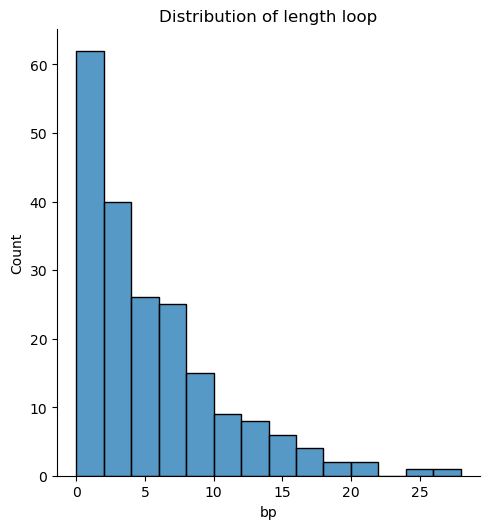

In [165]:
sns.displot(pd.concat([g4pqsconf['ll1'],g4pqsconf['ll2'],g4pqsconf['ll3']])) \
    .set(title='Distribution of length loop', xlabel='bp')

In [154]:
g4pqsconf['llall'] = g4pqsconf['ll1'] + g4pqsconf['ll2'] + g4pqsconf['ll3']

In [166]:
g4pqsconf['llall'].median()

14.0

In [167]:
g4pqsconf['llall'].describe()

count    67.000000
mean     15.089552
std       7.879262
min       3.000000
25%      10.000000
50%      14.000000
75%      21.000000
max      32.000000
Name: llall, dtype: float64

C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


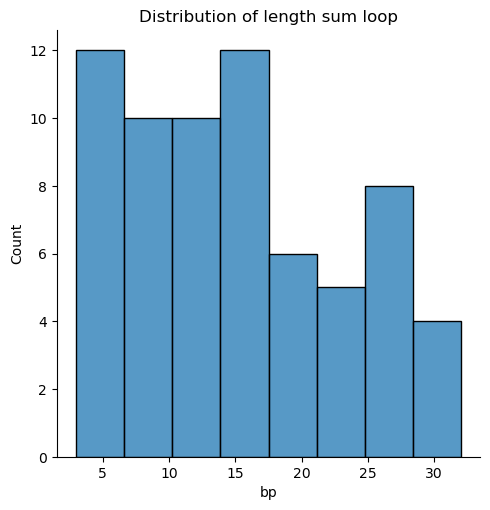

In [164]:
sns.displot(g4pqsconf['llall']).set(title='Distribution of length sum loop', xlabel='bp')

## NEW Add category to nucteotids

In [123]:
nuc_positions = []
for seq, start, G4_id in zip(g4pqsconf['sequence'], g4pqsconf['start'], g4pqsconf['G4_id']):
    for (i, j), (x, y) in zip(enumerate(seq, start=start), enumerate(seq)):
        row = [G4_id,x,i,j]
        nuc_positions.append(row)

In [124]:
nuc_positions = pd.DataFrame(nuc_positions, columns=['G4_id', 'pos_in_seq', 'pos_in_ref', 'nuc'])

In [125]:
nuc_positions

,G4_id,pos_in_seq,pos_in_ref,nuc
0,1,0,295,C
1,1,1,296,C
2,1,2,297,A
3,1,3,298,C
4,1,4,299,C
...,...,...,...,...
2418,67,23,16376,C
2419,67,24,16377,C
2420,67,25,16378,C
2421,67,26,16379,C


In [127]:
# sequence = '[CC(A)CC]AAA[CCCC]C[CCtC][CCCC]'  #for example
def categorize_sequence(sequence):  
    pattern = r'\[[A-Z]+\]|\([A-Z]+\)|\[[A-Z]+|[A-Z]+\]|[A-Z]+|[a-z]+'
    
    matches = re.findall(pattern, sequence)
    categories = []
    
    for match in matches:
        # print(match)
        if match.startswith('[') or match.endswith(']'):
            categories.extend(['Tetrad'] * len(match))
        elif match.startswith('(') and match.endswith(')'):
            categories.extend(['Bulges'] * len(match))
        elif match.isupper():
            categories.extend(['Loop'] * len(match))
        elif match.islower():
            categories.extend(['Mismatch'] * len(match))
    
    char_result = [char for char in sequence]

    return char_result, categories

In [127]:
# categorize_sequence('[CC(A)CC]AAA[CCCC]C[CCtC][CCCC]')

In [128]:
df_category = pd.DataFrame.from_records(g4pqsconf['pattern'].apply(categorize_sequence), 
                          columns=['char', 'category']) \
    .explode(['char', 'category']) \
    .reset_index(drop=True)

In [129]:
df_category

,char,category
0,[,Tetrad
1,C,Tetrad
2,C,Tetrad
3,(,Bulges
4,A,Bulges
...,...,...
3160,[,Tetrad
3161,C,Tetrad
3162,C,Tetrad
3163,C,Tetrad


In [129]:
df_category = df_category[~df_category['char'].isin(['[', ']', '(', ')'])].reset_index(drop=True)

In [130]:
# df_category = df_category.rename(columns={'char':'nuc'})
df_category['char'] = df_category['char'].str.upper()

In [131]:
df_category = nuc_positions.join(df_category).drop('char', axis=1)

In [132]:
df_category

,G4_id,pos_in_seq,pos_in_ref,nuc,category
0,1,0,295,C,Tetrad
1,1,1,296,C,Tetrad
2,1,2,297,A,Bulges
3,1,3,298,C,Tetrad
4,1,4,299,C,Tetrad
...,...,...,...,...,...
2418,67,23,16376,C,Tetrad
2419,67,24,16377,C,Tetrad
2420,67,25,16378,C,Tetrad
2421,67,26,16379,C,Tetrad


In [107]:
# df_category.to_csv('../data/processed/df_category_pqs.csv', index=False)

#### Choose only loops from each G4

In [68]:
df_category = pd.read_csv('../data/processed/df_category_pqs.csv')

In [70]:
df_category[df_category['category'] == 'Loop']

,G4_id,pos_in_seq,pos_in_ref,nuc,category
5,1,5,300,A,Loop
6,1,6,301,A,Loop
7,1,7,302,A,Loop
12,1,12,307,C,Loop
25,2,4,357,A,Loop
...,...,...,...,...,...
2412,67,17,16370,G,Loop
2413,67,18,16371,A,Loop
2414,67,19,16372,T,Loop
2415,67,20,16373,G,Loop


In [89]:
data_loops = []
for G4_id in df_category[df_category['category'] == 'Loop']['G4_id'].unique():
    row = []
    positions = df_category[(df_category['category'] == 'Loop') & (df_category['G4_id'] == G4_id)]['pos_in_ref'].values.tolist()
    seq = ''.join(df_category[(df_category['category'] == 'Loop') & (df_category['G4_id'] == G4_id)]['nuc'].values)

    row.append(G4_id)
    row.append('loops')
    row.append(positions)
    row.append(seq)
    data_loops.append(row)

In [91]:
data_loops
data_loops = pd.DataFrame(data=data_loops, columns = ['G4_id', 'side', 'positions', 'sequence'])
nuc_count = data_loops['sequence'].apply(lambda x: Counter(x))
nuc_count = pd.DataFrame.from_records(nuc_count).sort_index(axis=1)
data_loops = data_loops.join(nuc_count).fillna(0)

In [92]:
data_loops

,G4_id,side,positions,sequence,A,C,G,T
0,1,loops,"[300, 301, 302, 307]",AAAC,3,1.0,0.0,0.0
1,2,loops,"[357, 358, 359, 360, 361, 372, 373, 374, 379, ...",AAAAATAAAG,8,0.0,1.0,1.0
2,3,loops,"[464, 470, 471, 472, 473, 474, 475, 476, 477, ...",AATACTACTAATCTCATCAATACAAG,12,6.0,1.0,7.0
3,4,loops,"[538, 539, 540, 545, 546, 547, 548, 549, 550, ...",ATAGAACCAACCAAAAAAGACA,14,5.0,2.0,1.0
4,5,loops,"[961, 966, 967, 968, 969, 970, 971, 972, 973, ...",TAATAAAGCTAAAACTTGAGTTGTAAAAAA,16,2.0,4.0,8.0
...,...,...,...,...,...,...,...,...
62,63,loops,"[15530, 15531, 15532, 15533, 15534, 15535, 155...",TTAAACATA,5,1.0,0.0,3.0
63,64,loops,"[15633, 15634, 15635, 15636, 15637, 15638, 156...",TATCCATTAGCAATAATAT,8,3.0,1.0,7.0
64,65,loops,"[16170, 16171, 16172, 16177, 16178, 16179, 161...",AATATCAAAACT,7,2.0,0.0,3.0
65,66,loops,"[16263, 16264, 16265, 16269, 16270, 16271, 162...",TCAACTAGGATACCAACAAACCTAA,12,7.0,2.0,4.0


In [94]:
# data_loops.to_csv('../data/processed/data_loops_pqs.csv', index=False)

## Step 2
### Add columns: 
- 'bp_untill_next_G4' and 'bp_untill_previous_G4'
- 'up_win' and 'down_win 

### old

In [24]:
refG4 = pd.read_excel('../data/processed/refG4.xlsx')

In [25]:
g4conf = refG4[refG4['confirmed'] == 1]
g4conf = g4conf.reset_index(drop=True)

In [26]:
g4conf.head()

,seqnames,start,end,width,strand,score,max_score,threshold,window,sequence,confirmed,G4,note,start-100bp,end+100bp
0,"NC_012920.1 Homo sapiens mitochondrion, comple...",285,332,48,-,-1.25,-2.24,1,25,CAAAAAATTTCCACCAAACCCCCCCTCCCCCGCTTCTGGCCACAGCAC,1,G4,more than africa,185,432
1,"NC_012920.1 Homo sapiens mitochondrion, comple...",348,378,31,-,-1.10,-1.16,1,25,CCAAACCCCAAAAACAAAGAACCCTAACACC,1,UG4,less than africa,248,478
2,"NC_012920.1 Homo sapiens mitochondrion, comple...",418,592,175,-,-1.15,-1.88,1,25,CACTTTTAACAGTCACCCCCCAACTAACACATTATTTTCCCCTCCC...,1,G4,5 overlapping g4 in africa,318,692
3,"NC_012920.1 Homo sapiens mitochondrion, comple...",785,808,24,-,-1.21,-1.16,1,25,CGCTTAGCCTAGCCACACCCCCAC,1,G4,NaN,685,908
4,"NC_012920.1 Homo sapiens mitochondrion, comple...",954,984,31,-,-1.39,-1.48,1,25,CACCCCCTCCCCAATAAAGCTAAAACTCACC,1,G4,NaN,854,1084


In [27]:
g4conf = add_columns(g4conf)

In [28]:
# g4conf.to_csv('../data/processed/g4conf.csv', index=False)

### NEW pqsfinder

In [29]:
g4pqsconf.head()

,start,end,score,pattern,G4_id,sequence
0,295,315,64,[CC(A)CC]AAA[CCCC]C[CCtC][CCCC],1,CCACCAAACCCCCCCTCCCCC
1,353,387,33,[CCCC]AAAAA[C(AAAGAA)CCC]TAA[CaCC]AG[CC(TAA)CC],2,CCCCAAAAACAAAGAACCCTAACACCAGCCTAACC
2,458,506,55,[CC(T)CCC]A[CtCCC]ATACTACTAATCTCATCAATACAA[CCC...,3,CCTCCCACTCCCATACTACTAATCTCATCAATACAACCCCCGCCCATCC
3,534,571,88,[CCCC]ATA[CCCC]GAACCAACCAAA[CCCC]AAAGACA[CCCC],4,CCCCATACCCCGAACCAACCAAACCCCAAAGACACCCC
4,957,1002,22,[CCCC]T[CCCC]AATAAAGCTAAAACT[CaCC]TGAGTTGTAAAA...,5,CCCCTCCCCAATAAAGCTAAAACTCACCTGAGTTGTAAAAAACTCC


In [30]:
g4pqsconf = add_columns(g4pqsconf)

In [38]:
g4pqsconf.head()

,start,end,score,pattern,G4_id,sequence,bp_untill_next_G4,bp_untill_previous_G4,up_win,down_win
0,295,315,64,[CC(A)CC]AAA[CCCC]C[CCtC][CCCC],1,CCACCAAACCCCCCCTCCCCC,38,484,195,353
1,353,387,33,[CCCC]AAAAA[C(AAAGAA)CCC]TAA[CaCC]AG[CC(TAA)CC],2,CCCCAAAAACAAAGAACCCTAACACCAGCCTAACC,71,38,315,458
2,458,506,55,[CC(T)CCC]A[CtCCC]ATACTACTAATCTCATCAATACAA[CCC...,3,CCTCCCACTCCCATACTACTAATCTCATCAATACAACCCCCGCCCATCC,28,71,387,534
3,534,571,88,[CCCC]ATA[CCCC]GAACCAACCAAA[CCCC]AAAGACA[CCCC],4,CCCCATACCCCGAACCAACCAAACCCCAAAGACACCCC,386,28,506,671
4,957,1002,22,[CCCC]T[CCCC]AATAAAGCTAAAACT[CaCC]TGAGTTGTAAAA...,5,CCCCTCCCCAATAAAGCTAAAACTCACCTGAGTTGTAAAAAACTCC,680,386,857,1102


In [40]:
# g4pqsconf.to_csv('../data/processed/g4pqsconf.csv', index=False)

#### **Add +-15bp**

In [21]:
g4pqsconf

,start,end,score,pattern,G4_id,sequence,bp_untill_next_G4,bp_untill_previous_G4,up_win,down_win
0,295,315,64,[CC(A)CC]AAA[CCCC]C[CCtC][CCCC],1,CCACCAAACCCCCCCTCCCCC,38,484,195,353
1,353,387,33,[CCCC]AAAAA[C(AAAGAA)CCC]TAA[CaCC]AG[CC(TAA)CC],2,CCCCAAAAACAAAGAACCCTAACACCAGCCTAACC,71,38,315,458
2,458,506,55,[CC(T)CCC]A[CtCCC]ATACTACTAATCTCATCAATACAA[CCC...,3,CCTCCCACTCCCATACTACTAATCTCATCAATACAACCCCCGCCCATCC,28,71,387,534
3,534,571,88,[CCCC]ATA[CCCC]GAACCAACCAAA[CCCC]AAAGACA[CCCC],4,CCCCATACCCCGAACCAACCAAACCCCAAAGACACCCC,386,28,506,671
4,957,1002,22,[CCCC]T[CCCC]AATAAAGCTAAAACT[CaCC]TGAGTTGTAAAA...,5,CCCCTCCCCAATAAAGCTAAAACTCACCTGAGTTGTAAAAAACTCC,680,386,857,1102
...,...,...,...,...,...,...,...,...,...,...
62,15526,15556,83,[CCCC]TTAAACA[CCCC]T[CCCC]A[C(ATCAAG)CCC],63,CCCCTTAAACACCCCTCCCCACATCAAGCCC,68,8,15518,15624
63,15624,15668,29,[CCC(TATTA)C]TATCCAT[CC(TCAT)CC]TAGCAATAAT[CCC...,64,CCCTATTACTATCCATCCTCATCCTAGCAATAATCCCCATCCTCC,491,68,15556,15768
64,16159,16193,51,[C(ATAAAAA)CCC]AAT[CCaC]ATCAAAAC[CCCC]T[CCCC],65,CATAAAAACCCAATCCACATCAAAACCCCCTCCCC,67,491,16059,16260
65,16260,16296,44,[CCC]TCA[CCC]ACTAGGATACCAACAAACCTA[CCC]A[CCC],66,CCCTCACCCACTAGGATACCAACAAACCTACCCACCC,57,67,16193,16353


In [22]:
g4pqsconf = add_columns_15(g4pqsconf).fillna(0)

In [23]:
g4pqsconf

,start,end,score,pattern,G4_id,sequence,bp_untill_next_G4,bp_untill_previous_G4,up_win,down_win,15_up,15_down,30_up,30_down,45_up,45_down
0,295,315,64,[CC(A)CC]AAA[CCCC]C[CCtC][CCCC],1,CCACCAAACCCCCCCTCCCCC,38,484,195,353,280.0,330.0,265.0,345.0,250.0,0.0
1,353,387,33,[CCCC]AAAAA[C(AAAGAA)CCC]TAA[CaCC]AG[CC(TAA)CC],2,CCCCAAAAACAAAGAACCCTAACACCAGCCTAACC,71,38,315,458,338.0,402.0,323.0,417.0,0.0,432.0
2,458,506,55,[CC(T)CCC]A[CtCCC]ATACTACTAATCTCATCAATACAA[CCC...,3,CCTCCCACTCCCATACTACTAATCTCATCAATACAACCCCCGCCCATCC,28,71,387,534,443.0,521.0,428.0,0.0,413.0,0.0
3,534,571,88,[CCCC]ATA[CCCC]GAACCAACCAAA[CCCC]AAAGACA[CCCC],4,CCCCATACCCCGAACCAACCAAACCCCAAAGACACCCC,386,28,506,671,519.0,586.0,0.0,601.0,0.0,616.0
4,957,1002,22,[CCCC]T[CCCC]AATAAAGCTAAAACT[CaCC]TGAGTTGTAAAA...,5,CCCCTCCCCAATAAAGCTAAAACTCACCTGAGTTGTAAAAAACTCC,680,386,857,1102,942.0,1017.0,927.0,1032.0,912.0,1047.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,15526,15556,83,[CCCC]TTAAACA[CCCC]T[CCCC]A[C(ATCAAG)CCC],63,CCCCTTAAACACCCCTCCCCACATCAAGCCC,68,8,15518,15624,0.0,15571.0,0.0,15586.0,0.0,15601.0
63,15624,15668,29,[CCC(TATTA)C]TATCCAT[CC(TCAT)CC]TAGCAATAAT[CCC...,64,CCCTATTACTATCCATCCTCATCCTAGCAATAATCCCCATCCTCC,491,68,15556,15768,15609.0,15683.0,15594.0,15698.0,15579.0,15713.0
64,16159,16193,51,[C(ATAAAAA)CCC]AAT[CCaC]ATCAAAAC[CCCC]T[CCCC],65,CATAAAAACCCAATCCACATCAAAACCCCCTCCCC,67,491,16059,16260,16144.0,16208.0,16129.0,16223.0,16114.0,16238.0
65,16260,16296,44,[CCC]TCA[CCC]ACTAGGATACCAACAAACCTA[CCC]A[CCC],66,CCCTCACCCACTAGGATACCAACAAACCTACCCACCC,57,67,16193,16353,16245.0,16311.0,16230.0,16326.0,16215.0,16341.0


In [62]:
def make_15_col(df:pd.DataFrame, column_15:str, start_or_end:str, up=True):
    data_up = []
    for up_15, start, G4_id in zip(df[column_15], df[start_or_end], df['G4_id']):
        if up_15 > 0:
            row = []
            seq = ''
            if up == True:
                window = [*range(int(up_15), int(start))]
            elif up == False:
                window = [*range(int(start), int(up_15))]
            
            for pos in window:
                if pos != 3107:
                    seq += str(ref_annot[ref_annot['Pos'] == pos].Nuc.values[0])
                else:
                    seq += ''
            row.append(G4_id)
            row.append(column_15)
            if up == True:
                row.append(int(up_15))
                row.append(int(start))
            elif up == False:    
                row.append(int(start))
                row.append(int(up_15))
            row.append(seq)
    
            data_up.append(row)
        else:
            continue
    return data_up

In [63]:
data_15_col = make_15_col(g4pqsconf, '15_up', 'start', up=True) + \
make_15_col(g4pqsconf, '30_up', '15_up', up=True) + \
make_15_col(g4pqsconf, '45_up', '30_up', up=True) + \
make_15_col(g4pqsconf, '15_down', 'end', up=False) + \
make_15_col(g4pqsconf, '30_down', '15_down', up=False) + \
make_15_col(g4pqsconf, '45_down', '30_down', up=False)

In [64]:
data_15_col = pd.DataFrame(data=data_15_col, columns = ['G4_id', 'side', 'window_start', 'window_end', 'sequence'])
nuc_count_15 = data_15_col['sequence'].apply(lambda x: Counter(x))
nuc_count_15 = pd.DataFrame.from_records(nuc_count_15).sort_index(axis=1)
data_15_col = data_15_col.join(nuc_count_15).fillna(0)

In [65]:
data_15_col

,G4_id,side,window_start,window_end,sequence,A,C,G,T
0,1,15_up,280,295,CATAACAAAAAATTT,9.0,2.0,0.0,4
1,2,15_up,338,353,CACATCTCTGCCAAA,5.0,6.0,1.0,3
2,3,15_up,443,458,AACACATTATTTTCC,5.0,4.0,0.0,6
3,4,15_up,519,534,ACACACCGCTGCTAA,5.0,6.0,2.0,2
4,5,15_up,942,957,AGTGTTTTAGATCAC,4.0,2.0,3.0,6
...,...,...,...,...,...,...,...,...,...
353,63,45_down,15586,15601,TCTCCGATCCGTCCC,1.0,8.0,2.0,4
354,64,45_down,15698,15713,CGCCCACTAAGCCAA,5.0,7.0,2.0,1
355,65,45_down,16223,16238,CTCAACTATCACACA,6.0,6.0,0.0,3
356,66,45_down,16326,16341,ACCGTACATAGCACA,6.0,5.0,2.0,2


In [67]:
# data_15_col.to_csv('../data/processed/data_15_col_pqs.csv', index=False)

In [2]:
data_15_col = pd.read_csv('../data/processed/data_15_col_pqs.csv')

In [5]:
data_15_col[data_15_col['G4_id'] == 2]

,G4_id,side,window_start,window_end,sequence,A,C,G,T
1,2,15_up,338,353,CACATCTCTGCCAAA,5.0,6.0,1.0,3
66,2,30_up,323,338,GCCACAGCACTTAAA,6.0,5.0,2.0,2
180,2,15_down,387,402,CAGATTTCAAATTTT,5.0,2.0,1.0,7
245,2,30_down,402,417,ATCTTTTGGCGGTAT,2.0,2.0,4.0,7
303,2,45_down,417,432,GCACTTTTAACAGTC,4.0,4.0,2.0,5


## Step 3  
make windows for sliding window around G4 (make df_win)

### OLD  

New interval size:
- Take all confirmed G4   
- **Dont sort G4 by size between G4 >= 50 bp**  
- Obtain different interval size (0-100bp) between G4  

In [19]:
# G4_id = 38 hasnt downstream windows
# G4_id = 39 hasnt upsteram windows

In [87]:
# g4conf[(g4conf['G4_id'] == 38) | (g4conf['G4_id'] == 39)]

In [37]:
df_win = make_win_df(make_win_up(g4conf), make_win_down(g4conf))
df_win.head()

,G4_id,side,number_of_win,window_start,window_end,sequence,A,C,G,T
0,1,up,91,185,194,GCGAACATAC,4.0,3.0,2.0,1.0
1,1,up,90,186,195,CGAACATACT,4.0,3.0,1.0,2.0
2,1,up,89,187,196,GAACATACTT,4.0,2.0,1.0,3.0
3,1,up,88,188,197,AACATACTTA,5.0,2.0,0.0,3.0
4,1,up,87,189,198,ACATACTTAC,4.0,3.0,0.0,3.0


In [28]:
# df_win.to_csv('../data/processed/df_win.csv', index=False)

### NEW pqs

In [36]:
df_win_pqs = make_win_df(make_win_up(g4pqsconf), make_win_down(g4pqsconf))

In [37]:
df_win_pqs.head()

,G4_id,side,number_of_win,window_start,window_end,sequence,A,C,G,T
0,1,up,91,195,204,TTACTAAAGT,4.0,1.0,1.0,4.0
1,1,up,90,196,205,TACTAAAGTG,4.0,1.0,2.0,3.0
2,1,up,89,197,206,ACTAAAGTGT,4.0,1.0,2.0,3.0
3,1,up,88,198,207,CTAAAGTGTG,3.0,1.0,3.0,3.0
4,1,up,87,199,208,TAAAGTGTGT,3.0,0.0,3.0,4.0


In [43]:
# df_win_pqs.to_csv('../data/processed/df_win_pqs.csv', index=False)

# Data preparation around G4 for Cancer 

### Observed mutations Cancer dataset:

df_win_cancer - observed mutations from Cancer dataset with nucleotide frequencies from df_win
  
  Yuan, Y., Ju, Y.S., Kim, Y. et al. Comprehensive molecular characterization of mitochondrial genomes in human cancers. Nat Genet 52, 342–352 (2020). https://doi.org/10.1038/s41588-019-0557-x

Add mutations from Cancer dataset:

### OLD G4Hunter

In [85]:
df_cancers = pd.read_csv('../data/raw/mutations.csv')
df_win = pd.read_csv('../data/processed/df_win.csv')

In [52]:
df_win_cancer = collect_mut_cancer(df_cancers, df_win)

In [37]:
# df_win_cancer.to_csv('../data/processed/df_win_cancer.csv', index=False)

### NEW pqs

In [86]:
df_cancers = pd.read_csv('../data/raw/mutations.csv')
df_win_pqs = pd.read_csv('../data/processed/df_win_pqs.csv')

In [53]:
df_win_cancer_pqs = collect_mut_cancer(df_cancers, df_win_pqs, regime='2col')

In [56]:
# df_win_cancer_pqs.to_csv('../data/processed/df_win_cancer_pqs.csv', index=False)

# Data preparation around G4 for Human Global Tree

In [38]:
df_hgt = pd.read_table('../data/raw/fulltreeCodons.csv', sep=';')

In [40]:
with open('../data/raw/hgt_alignment.blast') as fin:
    while True:
        line = fin.readline()
        if 'Strand=Plus/Plus' in line:
            fin.readline()
            break
    qseq = ''
    rods = ''
    sseq = ''
    query, sbjct = 'Query', 'Sbjct'
    i = 0
    size = 60
    start = 14
    while query.startswith('Query') and sbjct.startswith('Sbjct'):
        i += 1
        query = fin.readline().strip()
        cur_rods = fin.readline()
        sbjct = fin.readline().strip()

        if len(query[start:start+size]) == size:
            qseq += query[start:start+size]
            sseq += sbjct[start:start+size]
            rods += cur_rods[start:start+size]
        else:
            pos = re.search('Query\s{2}(\d+)\s+[\w-]+\s+(\d+)', query).groups()
            size = int(pos[1]) - int(pos[0]) + 1
            
            qseq += query[start:start+size]
            sseq += sbjct[start:start+size]
            rods += cur_rods[start:start+size]
            break
            
        fin.readline()

In [41]:
print('sseq =', len(sseq), 'qseq =', len(qseq))

sseq = 16568 qseq = 16568


In [42]:
sseq = 'G' + sseq
qseq = 'G' + qseq

In [43]:
print('sseq =', len(sseq), 'qseq =', len(qseq))

sseq = 16569 qseq = 16569


In [44]:
dict_hgt = {i: qseq[i] for i in range(len(qseq))}
dict_ref = {i: sseq[i] for i in range(len(sseq))}

In [45]:
df_ali_hgt_to_ref = pd.DataFrame.from_dict(dict_ref, orient='index', columns=['nuc_ref']) \
    .reset_index() \
    .rename(columns={'index':'Pos'})

In [46]:
df_ali_hgt_to_ref['nuc_hgt'] = df_ali_hgt_to_ref['Pos'].map(dict_hgt)

In [47]:
df_ali_hgt_to_ref['Pos'] = range(1, len(df_ali_hgt_to_ref['Pos'])+1)

In [48]:
df_ali_hgt_to_ref = df_ali_hgt_to_ref.replace({'c':'C', 'n':'N', 't':'T', 'g':'G', 'a':'A'})

In [ ]:
df_unique = df_hgt[['ref_pos', 'nuc_ref_in_ali']].sort_values(by='ref_pos').drop_duplicates(subset=['ref_pos'])

In [50]:
df_unique = df_unique.reset_index(drop=True)

In [51]:
df_unique_sort = df_unique[~((df_unique['nuc_ref_in_ali'] == '-') | (df_unique['nuc_ref_in_ali'] == 'N'))][['ref_pos', 'nuc_ref_in_ali']]

In [52]:
df_unique_sort = df_unique_sort.reset_index(drop=True)

In [54]:
# Detele all posirions with N, -, and first position
a = df_ali_hgt_to_ref[~((df_ali_hgt_to_ref['nuc_hgt'] == 'N') | 
                        (df_ali_hgt_to_ref['nuc_hgt'] == '-') | 
                        (df_ali_hgt_to_ref['Pos'] == 1))].reset_index()

In [55]:
df_pos_ref_to_hgt = pd.concat([a, df_unique_sort], axis=1).rename(columns={'ref_pos':'hgt_ref_pos'}).set_index('index')

In [56]:
df_pos_ref_to_hgt.index.name = None

In [57]:
df_ali_hgt_to_ref = df_ali_hgt_to_ref.join(df_pos_ref_to_hgt, how='left', rsuffix='2') \
    .drop(columns=['Pos2', 'nuc_ref2', 'nuc_hgt2', 'nuc_hgt']) \
    .astype({'hgt_ref_pos':'Int64'})

In [58]:
# Add N in table
df_ali_hgt_to_ref.iloc[3106, df_ali_hgt_to_ref.columns.get_loc('hgt_ref_pos')] = 3106
df_ali_hgt_to_ref.iloc[3106, df_ali_hgt_to_ref.columns.get_loc('nuc_ref_in_ali')] = 'N'

In [59]:
for start, end, G4_id in zip(g4conf['start'], g4conf['end'], g4conf['G4_id']):
    df_ali_hgt_to_ref.loc[df_ali_hgt_to_ref.Pos.isin([*range(start, end+1)]),'G4'] = 1 #is position G4? 1-yes, 0-no
    df_ali_hgt_to_ref.loc[df_ali_hgt_to_ref.Pos.isin([*range(start, end+1)]),'G4_id'] = G4_id

In [60]:
for up_win, start, G4_id in zip(g4conf['up_win'], g4conf['start'], g4conf['G4_id']):
    df_ali_hgt_to_ref.loc[df_ali_hgt_to_ref.Pos.isin([*range(up_win, start+1)]),'up_win'] = G4_id

In [61]:
for end, down_win, G4_id in zip(g4conf['end'], g4conf['down_win'], g4conf['G4_id']):
    df_ali_hgt_to_ref.loc[df_ali_hgt_to_ref.Pos.isin([*range(end, down_win+1)]),'down_win'] = G4_id

In [62]:
df_ali_hgt_to_ref[['G4', 'G4_id', 'up_win', 'down_win']] = df_ali_hgt_to_ref[['G4',  'G4_id', 
                                                                              'up_win', 'down_win']].fillna(0)

In [63]:
df_ali_hgt_to_ref[['hgt_ref_pos', 'Pos', 'G4_id', 'G4', 'up_win', 'down_win']] \
    .rename(columns={'hgt_ref_pos':'ref_pos'}).head()

,ref_pos,Pos,G4_id,G4,up_win,down_win
0,<NA>,1,0.0,0.0,0.0,0.0
1,1,2,0.0,0.0,0.0,0.0
2,2,3,0.0,0.0,0.0,0.0
3,3,4,0.0,0.0,0.0,0.0
4,4,5,0.0,0.0,0.0,0.0


In [64]:
df_hgt_g4 = df_hgt \
    .merge(df_ali_hgt_to_ref[['hgt_ref_pos', 'Pos', 'G4_id', 'G4', 'up_win', 'down_win']] \
           .rename(columns={'hgt_ref_pos':'ref_pos'}), how='left') \
    .sort_values(by='ref_pos')

In [65]:
df_hgt_g4['Mut'] = df_hgt_g4.ancestor.str[2] + '>' + df_hgt_g4.descendant.str[2]

In [66]:
# df_hgt_g4.to_csv('data/processed/df_hgt_g4.csv', index=False)

### Collect observed mutations from HGT

In [67]:
df_hgt_g4 = pd.read_csv('data/processed/df_hgt_g4.csv')

C:\Users\777\AppData\Local\Temp\ipykernel_13856\3731285902.py:1: DtypeWarning: Columns (10,11,12,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hgt_g4 = pd.read_csv('data/processed/df_hgt_g4.csv')


In [68]:
# Extract mutations without gaps (-) and other (R, M, N, ect) bases in mut position:
df_hgt_g4 = df_hgt_g4[
    (df_hgt_g4.ancestor.str.lower().str.fullmatch("[acgt]{5}")) &
    (df_hgt_g4.descendant.str.lower().str.fullmatch("[acgt]{5}"))]

In [69]:
obs_mut_hgt_up = []
for up_win, Pos, Mut in zip(df_hgt_g4['up_win'], df_hgt_g4['Pos'], df_hgt_g4['Mut']):
    row = []
    
    if up_win > 0:
        row.append(up_win)
        row.append('up')
        row.append(Pos)
        row.append(Mut)
    else:
        continue
    
    obs_mut_hgt_up.append(row)

In [70]:
obs_mut_hgt_down = []
for down_win, Pos, Mut in zip(df_hgt_g4['down_win'], df_hgt_g4['Pos'], df_hgt_g4['Mut']):
    row = []
    
    if down_win > 0:
        row.append(down_win)
        row.append('down')
        row.append(Pos)
        row.append(Mut)
    else:
        continue
    
    obs_mut_hgt_down.append(row)

In [71]:
obs_mut_hgt = obs_mut_hgt_up + obs_mut_hgt_down

In [72]:
df_obs_mut_hgt = pd.DataFrame(data=obs_mut_hgt, columns=['G4_id', 'side', 'Pos', 'Mut'])

In [73]:
df_win = pd.read_csv('data/processed/df_win.csv')

In [74]:
Mut_hgt_win = []
for window_start, window_end in zip(df_win['window_start'], df_win['window_end']):
    row = []
    
    mut = df_obs_mut_hgt[(df_obs_mut_hgt['Pos'] >= window_start) & (df_obs_mut_hgt['Pos'] <= window_end)].Mut.tolist()
    
    row.append(mut)
    
    Mut_hgt_win.append(row)

In [75]:
df_Mut_hgt_win = pd.DataFrame(data=Mut_hgt_win)

In [77]:
obsMutG4_hgt = pd.DataFrame.from_records(df_Mut_hgt_win[0].apply(lambda x: Counter(x))).fillna(0).sort_index(axis=1)

In [78]:
df_win_hgt = df_win.join(obsMutG4_hgt)

In [79]:
df_win_hgt['number_of_Mut'] = df_win_hgt[['A>C','A>G','A>T','C>A','C>G','C>T','G>A','G>C','G>T','T>A','T>C','T>G']].sum(axis=1)

In [80]:
# df_win_hgt.to_csv('data/processed/df_win_hgt.csv', index=False)

# WITHIN G4 WITH SIDES

## Data preparation within G4 with sides

### OLD G4Hunter

In [57]:
g4conf = pd.read_csv('../data/processed/g4conf.csv')

In [67]:
df_win_within_sides = make_win_df(make_win_start_within(g4conf), make_win_end_within(g4conf))

In [66]:
# df_win_within_sides.to_csv('../data/processed/df_win_within_sides.csv', index=False)

### NEW pqs

In [69]:
df_win_within_sides_pqs = make_win_df(make_win_start_within(g4pqsconf), make_win_end_within(g4pqsconf))

In [72]:
# df_win_within_sides_pqs.to_csv('../data/processed/df_win_within_sides_pqs.csv', index=False)

## Within sides Cancer

### OLD G4Hunter

In [31]:
df_cancers = pd.read_csv('../data/raw/mutations.csv')
df_win_within_sides = pd.read_csv('../data/processed/df_win_within_sides.csv')

In [74]:
df_win_cancer_within_sides = collect_mut_cancer(df_cancers, df_win_within_sides, regime='2col')

In [76]:
# df_win_cancer_within_sides.to_csv('../data/processed/df_win_cancer_within_sides.csv', index=False)

### NEW pqs

In [81]:
df_cancers = pd.read_csv('../data/raw/mutations.csv')
df_win_within_sides_pqs = pd.read_csv('../data/processed/df_win_within_sides_pqs.csv')

In [82]:
df_win_cancer_within_sides_pqs = collect_mut_cancer(df_cancers, df_win_within_sides_pqs, regime='2col')

In [84]:
# df_win_cancer_within_sides_pqs.to_csv('../data/processed/df_win_cancer_within_sides_pqs.csv', index=False)

In [75]:
df_cancers = pd.read_csv('../data/raw/mutations.csv')
df_win_within_sides_pqs = pd.read_csv('../data/processed/df_win_within_sides_pqs.csv')

In [77]:
df_win_cancer_within_sides_pqs = collect_mut_cancer(df_cancers, df_win_within_sides_pqs, regime='2col')

In [168]:
df_win_cancer_within_sides_pqs

,G4_id,side,number_of_win,window_start,window_end,sequence,A,C,G,T,...,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,number_of_Mut
0,1,within_start,1,295,304,CCACCAAACC,4.0,6.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
1,1,within_start,2,296,305,CACCAAACCC,4.0,6.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
2,1,within_start,3,297,306,ACCAAACCCC,4.0,6.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3,1,within_start,4,298,307,CCAAACCCCC,3.0,7.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,within_start,5,299,308,CAAACCCCCC,3.0,7.0,0.0,0.0,...,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3434,67,within_end,13,16358,16367,TCGTCCCCAT,1.0,5.0,1.0,3.0,...,2.0,0.0,10.0,1.0,0.0,0.0,1.0,1.0,0.0,15.0
3435,67,within_end,14,16357,16366,CTCGTCCCCA,1.0,6.0,1.0,2.0,...,1.0,0.0,9.0,1.0,0.0,0.0,1.0,3.0,0.0,15.0
3436,67,within_end,15,16356,16365,TCTCGTCCCC,0.0,6.0,1.0,3.0,...,1.0,0.0,2.0,1.0,0.0,0.0,1.0,5.0,0.0,10.0
3437,67,within_end,16,16355,16364,TTCTCGTCCC,0.0,5.0,1.0,4.0,...,0.0,0.0,7.0,1.0,0.0,0.0,1.0,5.0,0.0,14.0


In [80]:
# df_win_cancer_within_sides_pqs.to_csv('../data/processed/df_win_cancer_within_sides_pqs.csv', index=False)

## Within sides HGT

In [78]:
df_hgt_g4 = pd.read_csv('../data/processed/df_hgt_g4.csv')
df_win_within_sides = pd.read_csv('../data/processed/df_win_within_sides.csv')

C:\Users\777\AppData\Local\Temp\ipykernel_13260\1406226394.py:1: DtypeWarning: Columns (10,11,12,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hgt_g4 = pd.read_csv('../data/processed/df_hgt_g4.csv')


In [79]:
# Extract mutations without gaps (-) and other (R, M, N, ect) bases in mut position:
df_hgt_g4 = df_hgt_g4[
    (df_hgt_g4.ancestor.str.lower().str.fullmatch("[acgt]{5}")) &
    (df_hgt_g4.descendant.str.lower().str.fullmatch("[acgt]{5}"))]

In [80]:
obs_mut_hgt_within_sides = []
for G4, G4_id, Pos, Mut in zip(df_hgt_g4['G4'], df_hgt_g4['G4_id'], df_hgt_g4['Pos'], df_hgt_g4['Mut']):
    row = []
    
    if G4 > 0:
        row.append(G4_id)
        row.append('within')
        row.append(Pos)
        row.append(Mut)
    else:
        continue
    
    obs_mut_hgt_within_sides.append(row)

In [81]:
df_obs_mut_hgt_within_sides = pd.DataFrame(data=obs_mut_hgt_within_sides, columns=['G4_id', 'side', 'Pos', 'Mut'])

In [82]:
Mut_hgt_win_within_sides = []
for window_start, window_end in zip(df_win_within_sides['window_start'], df_win_within_sides['window_end']):
    row = []
    
    mut = df_obs_mut_hgt_within_sides[(df_obs_mut_hgt_within_sides['Pos'] >= window_start) & 
        (df_obs_mut_hgt_within_sides['Pos'] <= window_end)]['Mut'].tolist()

    row.append(mut)
    
    Mut_hgt_win_within_sides.append(row)

In [83]:
df_Mut_hgt_win_within_sides = pd.DataFrame(data=Mut_hgt_win_within_sides)

In [84]:
obsMutG4_hgt_within_sides = pd.DataFrame.from_records(df_Mut_hgt_win_within_sides[0].apply(lambda x: Counter(x))) \
    .fillna(0) \
    .sort_index(axis=1)

In [85]:
df_win_hgt_within_sides = df_win_within_sides.join(obsMutG4_hgt_within_sides)

In [86]:
df_win_hgt_within_sides['number_of_Mut'] = df_win_hgt_within_sides[['A>C','A>G','A>T',
                                                        'C>A','C>G','C>T',
                                                        'G>A','G>C','G>T',
                                                        'T>A','T>C','T>G']].sum(axis=1)

In [87]:
df_win_hgt_within_sides.head()

,G4_id,side,number_of_win,window_start,window_end,sequence,A,C,G,T,...,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,number_of_Mut
0,1,within_start,1,285,294,CAAAAAATTT,6.0,1.0,0.0,3.0,...,0.0,0.0,76.0,5.0,0.0,0.0,8.0,88.0,0.0,189.0
1,1,within_start,2,286,295,AAAAAATTTC,6.0,1.0,0.0,3.0,...,26.0,0.0,128.0,5.0,0.0,0.0,9.0,140.0,0.0,346.0
2,1,within_start,3,287,296,AAAAATTTCC,5.0,2.0,0.0,3.0,...,28.0,0.0,152.0,5.0,0.0,0.0,9.0,163.0,0.0,397.0
3,1,within_start,4,288,297,AAAATTTCCA,5.0,2.0,0.0,3.0,...,34.0,0.0,152.0,72.0,0.0,0.0,9.0,163.0,0.0,548.0
4,1,within_start,5,289,298,AAATTTCCAC,4.0,3.0,0.0,3.0,...,35.0,0.0,152.0,67.0,0.0,0.0,9.0,163.0,0.0,539.0


In [89]:
# df_win_hgt_within_sides.to_csv('../data/processed/df_win_hgt_within_sides.csv', index=False)

# Data preparation within category, cancer. PQS

In [99]:
df_cancers = pd.read_csv('../data/raw/mutations.csv') 
df_category = pd.read_csv('../data/processed/df_category_pqs.csv')
data_15_col = pd.read_csv('../data/processed/data_15_col_pqs.csv')
data_loops = pd.read_csv('../data/processed/data_loops_pqs.csv') 

In [100]:
df_category_cancers = collect_mut_cancer(df_cancers, df_category, regime='pos')

In [19]:
# df_category_cancers.to_csv('../data/processed/df_category_cancers_pqs.csv', index=False)

### Statistic for categories

In [103]:
df_category_cancers

,G4_id,pos_in_seq,pos_in_ref,nuc,category,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,number_of_Mut
0,1,0,295,C,Tetrad,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,1,296,C,Tetrad,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,1,2,297,A,Bulges,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,1,3,298,C,Tetrad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,4,299,C,Tetrad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2418,67,23,16376,C,Tetrad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2419,67,24,16377,C,Tetrad,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2420,67,25,16378,C,Tetrad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2421,67,26,16379,C,Tetrad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
complementator = str.maketrans("ACGT", "TGCA") 

In [120]:
a = df_category_cancers.groupby(['G4_id','category']).agg({'A>C':'sum','A>G':'sum','A>T':'sum',
                                                'C>A':'sum','C>G':'sum','C>T':'sum',
                                                'G>A':'sum','G>C':'sum','G>T':'sum',
                                                'T>A':'sum','T>C':'sum','T>G':'sum'})

In [121]:
a.columns = a.columns.str.translate(complementator)

In [122]:
a

T>G   T>C  T>A  G>T  G>C   G>A  C>T  C>G  C>A  A>T  A>G  A>C
G4_id category                                                              
1     Bulges    0.0   2.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
      Loop      0.0   0.0  0.0  5.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
      Mismatch  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
      Tetrad    0.0   0.0  0.0  0.0  0.0   6.0  0.0  0.0  0.0  0.0  0.0  0.0
2     Bulges    0.0   2.0  0.0  0.0  0.0   0.0  1.0  0.0  1.0  0.0  0.0  0.0
...             ...   ...  ...  ...  ...   ...  ...  ...  ...  ...  ...  ...
65    Tetrad    0.0   0.0  0.0  4.0  1.0  23.0  0.0  0.0  0.0  0.0  0.0  0.0
66    Loop      0.0  12.0  0.0  0.0  0.0   5.0  1.0  0.0  0.0  0.0  1.0  0.0
      Tetrad    0.0   0.0  0.0  1.0  2.0  32.0  0.0  0.0  0.0  0.0  0.0  0.0
67    Loop      0.0   0.0  0.0  0.0  0.0   2.0  1.0  0.0  0.0  1.0  9.0  0.0
      Tetrad    0.0   0.0  0.0  3.0  0.0  15.0  0.0  0.0  0.0  0.0  0.0  0.0

[203 rows x 12 columns]

### +-15 interval

In [135]:
df_loop_cancer = collect_mut_cancer(df_cancers=df_cancers, df_win=data_loops, regime='1col')

In [136]:
df_15_col_cancer = collect_mut_cancer(df_cancers=df_cancers, df_win=data_15_col, regime='2col')

In [139]:
# df_loop_cancer.to_csv('../data/processed/df_loop_cancer_pqs.csv', index=False)
# df_15_col_cancer.to_csv('../data/processed/df_15_col_cancer_pqs.csv', index=False)

# OTHER

## Location of g4

In [58]:
g4_location = []
for G4_id, start, end in zip(g4conf['G4_id'], g4conf['start'], g4conf['end']):
    location = []
    row = []
    for i in range(start, end+1):
        # row.append(G4_id)
        # row.append(i)
        location.append(ref_annot[ref_annot['Pos'] == i]['Type'].to_string(index=False))
        
    row.append(G4_id)
    row.append('/'.join(list(set(location))))
    g4_location.append(row)

In [59]:
g4_location

[[1, 'D-loop'],
 [2, 'D-loop'],
 [3, 'D-loop/tRNA'],
 [4, 'rRNA'],
 [5, 'rRNA'],
 [6, 'tRNA/rRNA'],
 [7, 'rRNA'],
 [8, 'rRNA'],
 [9, 'rRNA'],
 [10, 'rRNA'],
 [11, 'CDS'],
 [12, 'CDS'],
 [13, 'CDS'],
 [14, 'CDS'],
 [15, 'CDS'],
 [16, 'CDS'],
 [17, 'tRNA'],
 [18, 'tRNA/CDS'],
 [19, 'CDS'],
 [20, 'CDS'],
 [21, 'CDS'],
 [22, 'CDS'],
 [23, 'CDS'],
 [24, 'tRNA/NaN/CDS'],
 [25, 'CDS'],
 [26, 'CDS'],
 [27, 'CDS'],
 [28, 'CDS'],
 [29, 'CDS'],
 [30, 'CDS'],
 [31, 'CDS'],
 [32, 'NaN/CDS/tRNA'],
 [33, 'CDS'],
 [34, 'CDS'],
 [35, 'CDS'],
 [36, 'CDS'],
 [37, 'CDS'],
 [38, 'CDS'],
 [39, 'CDS'],
 [40, 'CDS'],
 [41, 'CDS'],
 [42, 'CDS'],
 [43, 'CDS'],
 [44, 'CDS'],
 [45, 'CDS'],
 [46, 'CDS'],
 [47, 'CDS'],
 [48, 'CDS'],
 [49, 'CDS'],
 [50, 'CDS'],
 [51, 'CDS'],
 [52, 'CDS'],
 [53, 'CDS'],
 [54, 'CDS'],
 [55, 'CDS'],
 [56, 'CDS'],
 [57, 'CDS'],
 [58, 'CDS'],
 [59, 'CDS'],
 [60, 'CDS'],
 [61, 'CDS'],
 [62, 'CDS'],
 [63, 'CDS'],
 [64, 'CDS'],
 [65, 'CDS'],
 [66, 'CDS'],
 [67, 'CDS'],
 [68, 'CDS'],
 [69, '

In [60]:
df_g4_location = pd.DataFrame(data=g4_location, columns=['G4_id', 'location'])

In [61]:
df_g4_location

,G4_id,location
0,1,D-loop
1,2,D-loop
2,3,D-loop/tRNA
3,4,rRNA
4,5,rRNA
...,...,...
69,70,CDS
70,71,D-loop
71,72,D-loop
72,73,D-loop


In [65]:
df_g4_location = df_g4_location.set_index('G4_id')['location'].str.split('/', expand=True) \
    .stack() \
    .reset_index(name='location') \
    .drop('level_1', axis=1)

In [66]:
df_g4_location

,G4_id,location
0,1,D-loop
1,2,D-loop
2,3,D-loop
3,3,tRNA
4,4,rRNA
...,...,...
76,70,CDS
77,71,D-loop
78,72,D-loop
79,73,D-loop


In [64]:
# df_g4_location.to_csv('../data/processed/df_g4_location.csv', index=False)

In [7]:
g4conf.columns

Index(['seqnames', 'start', 'end', 'width', 'strand', 'score', 'max_score',
       'threshold', 'window', 'sequence', 'confirmed', 'G4', 'note',
       'start-100bp', 'end+100bp', 'start-50bp', 'end+50bp',
       'bp_untill_next_G4', 'bp_untill_previous_G4', 'G4_id', 'up_win',
       'down_win'],
      dtype='object')

In [13]:
df_g4_type = g4conf[['G4_id', 'G4']].rename(columns={'G4':'Type_of_G4'})

In [17]:
# df_g4_type.to_csv('../data/processed/df_g4_type.csv', index=False)

## G4 location *in vivo* (doi.org/10.1093/nar/gkad535)

In [34]:
G4_peaks = [[1, 2425, 3986], [2, 4330, 4624], [3, 5570, 7168], [4, 7139, 7559], [5, 7800, 8276], [6, 8958, 9869], [7, 12762, 13771]]

In [41]:
df_g4_vivo_peaks = pd.DataFrame(G4_peaks, columns=['number', 'start', 'end'])

In [42]:
df_g4_vivo_peaks

,number,start,end
0,1,2425,3986
1,2,4330,4624
2,3,5570,7168
3,4,7139,7559
4,5,7800,8276
5,6,8958,9869
6,7,12762,13771


In [57]:
# g4conf

In [52]:
g4_vivo = []
for start, end, G4_id in zip(g4conf['start'], g4conf['end'], g4conf['G4_id']):
    for p_start, p_end, number in zip(df_g4_vivo_peaks['start'], df_g4_vivo_peaks['end'], df_g4_vivo_peaks['number']):
        row = []
        if start in range(p_start, p_end) or end in range(p_start, p_end):
            row.append(number)
            row.append(G4_id)
            row.append(1)
            g4_vivo.append(row)

In [53]:
df_g4_vivo = pd.DataFrame(g4_vivo, columns=['peak_number', 'G4_id', 'in_vivo'])

In [54]:
df_g4_vivo

,peak_number,G4_id,in_vivo
0,1,9,1
1,1,10,1
2,1,11,1
3,1,12,1
4,1,13,1
5,2,17,1
6,2,18,1
7,3,24,1
8,3,25,1
9,3,26,1


In [56]:
# df_g4_vivo.to_csv('../data/processed/df_g4_vivo.csv', index=False)

## Check decrease of С>T  
Make new windows which cover all length G4 and +-25 bp 


In [7]:
g4conf

,seqnames,start,end,width,strand,score,max_score,threshold,window,sequence,...,note,start-100bp,end+100bp,start-50bp,end+50bp,bp_untill_next_G4,bp_untill_previous_G4,G4_id,up_win,down_win
0,"NC_012920.1 Homo sapiens mitochondrion, comple...",285,332,48,-,-1.250,-2.24,1,25,CAAAAAATTTCCACCAAACCCCCCCTCCCCCGCTTCTGGCCACAGCAC,...,more than africa,185,432,235,382,16,294,1,185,348
1,"NC_012920.1 Homo sapiens mitochondrion, comple...",348,378,31,-,-1.100,-1.16,1,25,CCAAACCCCAAAAACAAAGAACCCTAACACC,...,less than africa,248,478,298,428,40,16,2,332,418
2,"NC_012920.1 Homo sapiens mitochondrion, comple...",418,592,175,-,-1.150,-1.88,1,25,CACTTTTAACAGTCACCCCCCAACTAACACATTATTTTCCCCTCCC...,...,5 overlapping g4 in africa,318,692,368,642,193,40,3,378,692
3,"NC_012920.1 Homo sapiens mitochondrion, comple...",785,808,24,-,-1.210,-1.16,1,25,CGCTTAGCCTAGCCACACCCCCAC,...,NaN,685,908,735,858,146,193,4,685,908
4,"NC_012920.1 Homo sapiens mitochondrion, comple...",954,984,31,-,-1.390,-1.48,1,25,CACCCCCTCCCCAATAAAGCTAAAACTCACC,...,NaN,854,1084,904,1034,683,146,5,854,1084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,"NC_012920.1 Homo sapiens mitochondrion, comple...",15636,15683,48,-,-0.896,-1.16,1,25,CCATCCTCATCCTAGCAATAATCCCCATCCTCCATATATCCAAACAAC,...,more than africa,15536,15783,15586,15733,484,80,70,15556,15783
70,"NC_012920.1 Homo sapiens mitochondrion, comple...",16167,16211,45,-,-1.160,-1.80,1,25,CCCAATCCACATCAAAACCCCCTCCCCATGCTTACAAGCAAGTAC,...,more than africa,16067,16311,16117,16261,28,484,71,16067,16239
71,"NC_012920.1 Homo sapiens mitochondrion, comple...",16239,16301,63,-,-0.968,-1.40,1,25,CAACTGCAACTCCAAAGCCACCCCTCACCCACTAGGATACCAACAA...,...,more than africa,16139,16401,16189,16351,43,28,72,16211,16344
72,"NC_012920.1 Homo sapiens mitochondrion, comple...",16344,16382,39,-,-1.210,-1.48,1,25,CAGTCAAATCCCTTCTCGTCCCCATGGATGACCCCCCTC,...,more than africa,16244,16482,16294,16432,145,43,73,16301,16482


In [6]:
df_25bp = g4conf[(g4conf['bp_untill_previous_G4'] >= 25) & 
            (g4conf['bp_untill_next_G4'] >= 25) & 
            (g4conf['end'] + 25 <= 16569)]

In [7]:
df_25bp

,seqnames,start,end,width,strand,score,max_score,threshold,window,sequence,...,note,start-100bp,end+100bp,start-50bp,end+50bp,bp_untill_next_G4,bp_untill_previous_G4,G4_id,up_win,down_win
2,"NC_012920.1 Homo sapiens mitochondrion, comple...",418,592,175,-,-1.150,-1.88,1,25,CACTTTTAACAGTCACCCCCCAACTAACACATTATTTTCCCCTCCC...,...,5 overlapping g4 in africa,318,692,368,642,193,40,3,378,692
3,"NC_012920.1 Homo sapiens mitochondrion, comple...",785,808,24,-,-1.210,-1.16,1,25,CGCTTAGCCTAGCCACACCCCCAC,...,NaN,685,908,735,858,146,193,4,685,908
4,"NC_012920.1 Homo sapiens mitochondrion, comple...",954,984,31,-,-1.390,-1.48,1,25,CACCCCCTCCCCAATAAAGCTAAAACTCACC,...,NaN,854,1084,904,1034,683,146,5,854,1084
5,"NC_012920.1 Homo sapiens mitochondrion, comple...",1667,1707,41,-,-1.020,-1.48,1,25,CTGAGCTAAACCTAGCCCCAAACCCACTCCACCTTACTACC,...,more than in africa,1567,1807,1617,1757,350,683,6,1567,1807
6,"NC_012920.1 Homo sapiens mitochondrion, comple...",2057,2079,23,-,-1.520,-1.40,1,25,CCCACAGAACCCTCTAAATCCCC,...,NaN,1957,2179,2007,2129,133,350,7,1957,2179
7,"NC_012920.1 Homo sapiens mitochondrion, comple...",2212,2236,25,-,-1.000,-1.00,1,25,CAACACCCACTACCTAAAAAATCCC,...,NaN,2112,2336,2162,2286,912,133,8,2112,2336
10,"NC_012920.1 Homo sapiens mitochondrion, comple...",3471,3604,134,-,-1.170,-2.76,1,25,CTTCACCAAAGAGCCCCTAAAACCCGCCACATCTACCATCACCCTC...,...,5 overlapping g4 in africa,3371,3704,3421,3654,270,249,11,3371,3704
11,"NC_012920.1 Homo sapiens mitochondrion, comple...",3874,3909,36,-,-0.917,-1.28,1,25,CTAGCAGAGACCAACCGAACCCCCTTCGACCTTGCC,...,NaN,3774,4009,3824,3959,42,270,12,3774,3951
12,"NC_012920.1 Homo sapiens mitochondrion, comple...",3951,3984,34,-,-0.882,-1.20,1,25,CGCCGCAGGCCCCTTCGCCCTATTCTTCATAGCC,...,more than africa,3851,4084,3901,4034,102,42,13,3909,4084
15,"NC_012920.1 Homo sapiens mitochondrion, comple...",4228,4260,33,-,-1.210,-1.28,1,25,CCCATTACAATCTCCAGCATTCCCCCTCAAACC,...,NaN,4128,4360,4178,4310,112,67,16,4161,4360


In [58]:
# df_25bp['start'] = df_25bp['start'].apply(lambda x: x-25)
# df_25bp['end'] = df_25bp['end'].apply(lambda x: x+25)

In [10]:
data_check_start = []

for start, end, G4_id in zip(df_25bp['start'], 
                             df_25bp['end'], 
                             df_25bp['G4_id']):
    
    number_of_win = 0
    
    for i in range(start-25, end+25):
        row = []
        
        if i+WINDOW_SIZE <= end+25:
            window = [*range(i, i + WINDOW_SIZE)]       
        else:
            break

        window_seq = ''
        for pos in window:
            if pos != 3107:
                window_seq += str(ref_annot[ref_annot['Pos'] == pos].Nuc.values[0])
            else:
                window_seq += ''
        
        # print(i, window, WINDOW_SIZE, end)  
        
        number_of_win += 1

        row.append(G4_id)
        row.append('check_start')
        row.append(number_of_win)
        row.append(window[0])
        row.append(window[-1])
        row.append(window_seq)
        
        data_check_start.append(row)
# print(data_check_start)

In [15]:
data_check_end = []

for start, end, G4_id in zip(df_25bp['start'], 
                             df_25bp['end'], 
                             df_25bp['G4_id']):
    
    number_of_win = 0
    
    for i in range(end+25, start-25, -1):
        row = []

        
        if i+WINDOW_SIZE > end+25:
            continue  
        elif (i+WINDOW_SIZE <= end+25):
            window = [*range(i, i + WINDOW_SIZE)]       
        else:
            continue

        window_seq = ''
        for pos in window:
            if pos != 3107:
                window_seq += str(ref_annot[ref_annot['Pos'] == pos].Nuc.values[0])
            else:
                window_seq += ''
        
        number_of_win += 1

        row.append(G4_id)
        row.append('check_end')
        row.append(number_of_win)
        row.append(window[0])
        row.append(window[-1])
        row.append(window_seq)
        
        data_check_end.append(row)
# print(data_check_end)

In [16]:
data_check_sides = data_check_start + data_check_end

In [24]:
# data_check_sides

In [18]:
df_win_check_sides = pd.DataFrame(data=data_check_sides, 
                             columns = ['G4_id', 'side', 'number_of_win', 'window_start', 'window_end', 'sequence'])

In [23]:
df_win_check_sides[(df_win_check_sides['side'] == 'check_end') & (df_win_check_sides['G4_id'] == 3)]

,G4_id,side,number_of_win,window_start,window_end,sequence
4901,3,check_end,1,607,616,CACTGAAAAT
4902,3,check_end,2,606,615,ACACTGAAAA
4903,3,check_end,3,605,614,TACACTGAAA
4904,3,check_end,4,604,613,ATACACTGAA
4905,3,check_end,5,603,612,AATACACTGA
...,...,...,...,...,...,...
5110,3,check_end,210,398,407,TTTTATCTTT
5111,3,check_end,211,397,406,ATTTTATCTT
5112,3,check_end,212,396,405,AATTTTATCT
5113,3,check_end,213,395,404,AAATTTTATC


In [25]:
nuc_count_win_check_sides = df_win_check_sides['sequence'].apply(lambda x: Counter(x))

In [26]:
nuc_count_df_win_check_sides = pd.DataFrame.from_records(nuc_count_win_check_sides).sort_index(axis=1)

In [27]:
df_win_check_sides = df_win_check_sides.join(nuc_count_df_win_check_sides).fillna(0)

In [28]:
df_win_check_sides

,G4_id,side,number_of_win,window_start,window_end,sequence,A,C,G,T
0,3,check_start,1,393,402,TCAAATTTTA,4.0,1.0,0.0,5.0
1,3,check_start,2,394,403,CAAATTTTAT,4.0,1.0,0.0,5.0
2,3,check_start,3,395,404,AAATTTTATC,4.0,1.0,0.0,5.0
3,3,check_start,4,396,405,AATTTTATCT,3.0,1.0,0.0,6.0
4,3,check_start,5,397,406,ATTTTATCTT,2.0,1.0,0.0,7.0
...,...,...,...,...,...,...,...,...,...,...
9743,73,check_end,74,16324,16333,TTACCGTACA,3.0,3.0,1.0,3.0
9744,73,check_end,75,16323,16332,TTTACCGTAC,2.0,3.0,1.0,4.0
9745,73,check_end,76,16322,16331,ATTTACCGTA,3.0,2.0,1.0,4.0
9746,73,check_end,77,16321,16330,CATTTACCGT,2.0,3.0,1.0,4.0


In [30]:
# df_win_check_sides.to_csv('../data/processed/df_win_check_sides.csv', index=False)

Collect mutations from cancer dataset

In [32]:
df_cancers = pd.read_csv('../data/raw/mutations.csv')

In [33]:
df_win_check_sides = pd.read_csv('../data/processed/df_win_check_sides.csv')

In [39]:
Mut_win_check_sides = []
for window_start, window_end in zip(df_win_check_sides['window_start'], df_win_check_sides['window_end']):
    row = [*range(window_start, window_end)]
    Mut_win_check_sides.append(str(df_cancers[df_cancers['Pos'].isin(row)].Mut.values))

In [40]:
Mut_win_df_check_sides = pd.DataFrame(Mut_win_check_sides)

In [41]:
Mut_win_df_check_sides[0] = Mut_win_df_check_sides[0].str.findall("[A-T]>[A-T]")

In [42]:
obsMutwin_check_sides = pd.DataFrame.from_records(Mut_win_df_check_sides[0].apply(lambda x: Counter(x))) \
    .fillna(0) \
    .sort_index(axis=1)

In [43]:
df_win_cancer_check_sides = df_win_check_sides.join(obsMutwin_check_sides)

In [44]:
df_win_cancer_check_sides['number_of_Mut'] = df_win_cancer_check_sides[['A>C','A>G','A>T',
                                                              'C>A','C>G','C>T',
                                                              'G>A','G>C','G>T',
                                                              'T>A','T>C','T>G']].sum(axis=1)

In [45]:
df_win_cancer_check_sides.head()

,G4_id,side,number_of_win,window_start,window_end,sequence,A,C,G,T,...,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,number_of_Mut
0,3,check_start,1,393,402,TCAAATTTTA,4.0,1.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,check_start,2,394,403,CAAATTTTAT,4.0,1.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,check_start,3,395,404,AAATTTTATC,4.0,1.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,3,check_start,4,396,405,AATTTTATCT,3.0,1.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,3,check_start,5,397,406,ATTTTATCTT,2.0,1.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [47]:
# df_win_cancer_check_sides.to_csv('../data/processed/df_win_cancer_check_sides.csv', index=False)